In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='609f369b-fbb6-46c5-9e8b-bfe577bf8cc4', project_access_token='p-67c5fb8e8d0cc5c18037c52ead18004a464eb338')
pc = project.project_context

In [2]:
# START CODE BLOCK
# cos2file - takes an object from Cloud Object Storage and writes it to file on container file system.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: project object defined in project token
# data_path: the directory to write the file
# filename: name of the file in COS

import os
def cos2file(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    open( data_dir + '/' + filename, 'wb').write(p.get_file(filename).read())

# file2cos - takes file on container file system and writes it to an object in Cloud Object Storage.
# Uses the IBM project_lib library.
# See https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/project-lib-python.html
# Arguments:
# p: prooject object defined in project token
# data_path: the directory to read the file from
# filename: name of the file on container file system

import os
def file2cos(p,data_path,filename):
    data_dir = p.project_context.home + data_path
    path_to_file = data_dir + '/' + filename
    if os.path.exists(path_to_file):
        file_object = open(path_to_file, 'rb')
        p.save_data(filename, file_object, set_project_asset=True, overwrite=True)
    else:
        print("file2cos error: File not found")
# END CODE BLOCK

In [3]:
cos2file(project, '/data', 'aavail-streams.csv')
cos2file(project, '/data', 'aavail-customers.db')

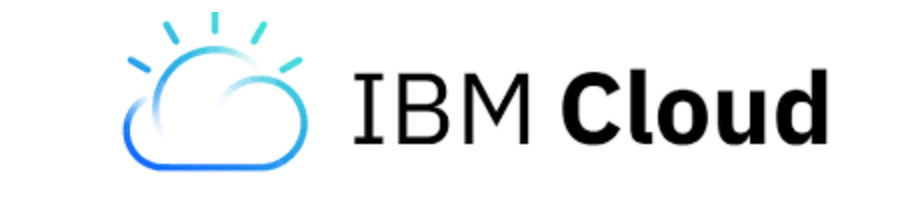
# Case Study - Data ingestion

The goal of this case study is to put into practice the important concepts from module 1.  We will go through the basic process that begins with refining the business opportunity and ensuring that it is articulated using a scientific thought process.

The business opportunity and case study was first mentioned in Unit 2 of module 1 and like the AAVIAL company itself these data were created for learning purposes.  We will be using the AAVAIL example as a basis for this case study.  [Watch the video again](https://vimeo.com/348708995) if you need a refresher.  You will be gathering data from several provided sources, staging it for quality assurance and saving it in a target destination that is most appropriate.

Watch the video to review the important concepts from the units you just covered and to see an overview of the objectives for this case study.

In [4]:
from IPython.display import IFrame
IFrame('https://player.vimeo.com/video/354996550', width=600,height=400)

## Case study overall objectives

1. Gather all relevant data from the sources of provided data
2. Implement several checks for quality assurance 
3. Take the initial steps towards automation of the ingestion pipeline

## Getting started

Download this notebook and open it locally using a Jupyter server. Alternatively you may use Watson Studio.  To make using Watson Studio easier we have provided a zip archive file containing the files needed to complete this case study in Watson Studio. See the [Getting started with Watson Studio](m1-u5-5-watson-studio.rst) page.

**You will need the following files to complete this case study**

* [m1-u6-case-study.ipynb](m1-u6-case-study.ipynb)
* [m1-u6-case-study-solution.ipynb](./notebooks/m1-u6-case-study-solution.ipynb)
* [aavail-customers.db](./data/aavail-customers.db)
* [aavail-steams.csv](./data/aavail-streams.csv)

1. Fill in all of the places in this notebook marked with ***YOUR CODE HERE*** or ***YOUR ANSWER HERE***
2. When you have finished the case study there will be a short quiz

You may review the rest of this content as part of the notebook, but once you are ready to get started be ensure that you are working with a *live* version either as part of Watson Studio or locally.

## Data Sources

The data you will be sourcing from is contained in two sources.

1. A database ([SQLite](https://www.sqlite.org/index.html)) of `customer` data
2. A [CSV file](https://en.wikipedia.org/wiki/Comma-separated_values) of `stream` level data

   >You will create a simple data pipeline that
   (1) simplifies the data for future analysis
   (2) performs quality assurance checks.

The process of building *the data ingestion pipeline* entails extracting data, transforming it, and loading it into an appropriate data storage technology.  When constructing a pipeline it is important to keep in mind that they generally process data in batches.  For example, data may be compiled during the day and the batch could be processed during the night.  The data pipeline may also be optimized to execute as a streaming computation (i.e., every event is handled as it occurs).

## PART 1: Gathering the data

The following is an [Entity Relationship Diagram (ERD)](https://en.wikipedia.org/wiki/Entity%E2%80%93relationship_model) that details the tables and contents of the database.

<!-- <img src="./images/aavail-schema.svg" alt="customer database schema" style="width: 600px;"/> -->
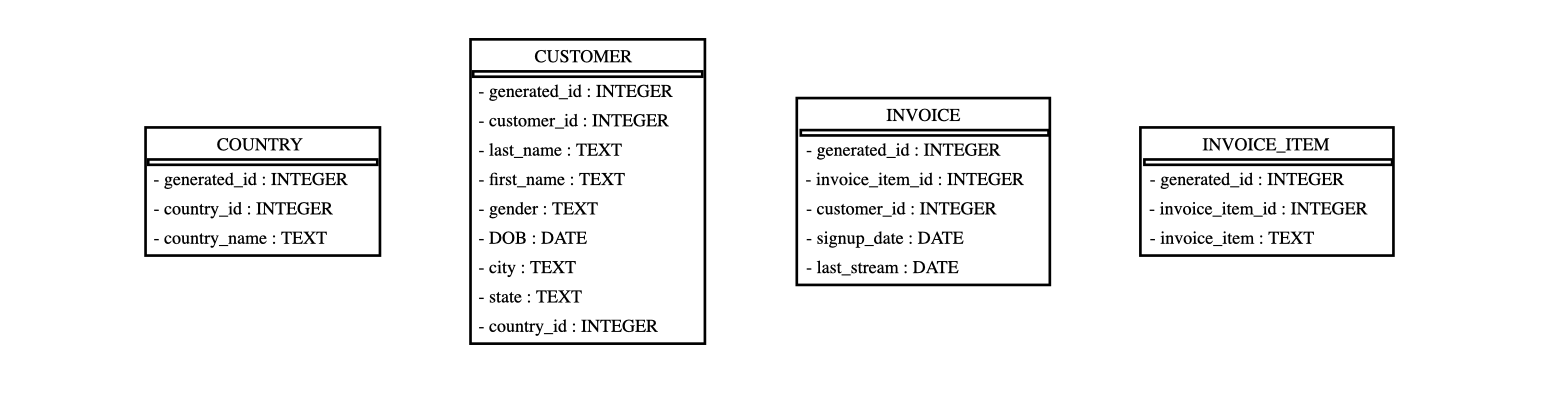

In [118]:
## all the imports you will need for this case study
import os
import pandas as pd
import numpy as np
import sqlite3

# age
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin

## specify the directory you saved the data in
data_dir = os.path.join("..","data")

Much of the data exist in a database.  You can connect to is using the `sqlite3` Python package with the function shown below.  Note that is is good practice to wrap your connect functions in a [try-except statement](https://docs.python.org/3/tutorial/errors.html) to cleanly handle exceptions.

In [6]:
def connect_db(file_path):
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db\n")
    except Error as e:
        print("...unsuccessful connection\n",e)
    
    return(conn)

In [7]:
## make the connection to the database
conn = connect_db(os.path.join(data_dir,"aavail-customers.db"))

## print the table names
tables = [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table';")]
print(tables)

...successfully connected to db

['CUSTOMER', 'INVOICE', 'INVOICE_ITEM', 'COUNTRY']


### QUESTION 1:

**extract the relevant data from the DB**

Query the database and extract the following data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).
 
* Customer ID (integer)
* Last name
* First name
* DOB
* City
* State
* Country (the name NOT the country_id)
* Gender

Remember that that SQL is case-insensitive, but it is traditional to use ALL CAPS for SQL keywords. It is also a convention to end SQL statements with a semi-colon.  

#### Resources

* [W3 schools SQL tutorial](https://www.w3schools.com/sql)
* [W3 schools SQL joins](https://www.w3schools.com/sql/sql_join.asp)

In [91]:
## YOUR CODE HERE

query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender, inv.invoice_item_id, item.invoice_item
FROM CUSTOMER cu
INNER JOIN COUNTRY co, INVOICE inv, INVOICE_ITEM item
ON cu.country_id = co.country_id AND 
cu.customer_id = inv.customer_id AND
inv.invoice_item_id = item.invoice_item_id
"""

c = conn.cursor()

columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender","invoice_item_id", "invoice_item"]
df_db = pd.DataFrame(data = list(c.execute(query)), columns = columns)

In [92]:
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country,gender,invoice_item_id,invoice_item
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m,2,aavail_premium
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f,3,aavail_unlimited
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f,2,aavail_premium
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m,1,aavail_basic
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m,2,aavail_premium


### QUESTION 2:

**Extract the relevant data from the CSV file**

For each ```customer_id``` determine if a customer has stopped their subscription or not and save it in a dictionary or another data container.

In [142]:
df_streams = pd.read_csv(os.path.join(data_dir,r"aavail-streams.csv"))

In [148]:
## YOUR CODE HERE
# df_streams.loc[:, ["customer_id", "subscription_stopped"]].drop_duplicates()
user_stoped = {}
user_num_streams = {}
for name, group in df_streams.groupby("customer_id"):
    if (group["subscription_stopped"] == 0).all():
        user_stoped[name] = 0
    else:
        user_stoped[name] = 1
    
    user_num_streams[name] = group.shape[0]

## PART 2: Checks for quality assurance

Sometimes it is known in advance which types of data integrity issues to expect, but other times it is during the Exploratory Data Analysis (EDA) process that these issues are identified.  After extracting data it is important to include checks for quality assurance even on the first pass through the AI workflow.  Here you will combine the data into a single structure and provide a couple checks for quality assurance.

### QUESTION 3: 

**Implement checks for quality assurance**

1. Remove any repeat customers based on ```customer_id```
2. Remove stream data that do not have an associated ```stream_id```
3. Check for missing values

In [95]:
# YOUR CODE HERE
print("\nCleaning Summary\n{}".format("-"*35))
df_db = df_db.drop_duplicates()
assert df_db["customer_id"].unique().shape[0] == df_db.shape[0]


missing_stream_ids = df_streams['stream_id'].isna()
if True in missing_stream_ids:
    df_streams = df_streams[~missing_stream_ids]
print("Removed {} missing stream ids".format(np.where(missing_stream_ids==True)[0].size))


print("\nMissing Value Summary\n{}".format("-"*35))
print("\ndf_db\n{}".format("-"*15))
print(df_db.isnull().sum(axis = 0))
print("\ndf_streams\n{}".format("-"*15))
print(df_streams.isnull().sum(axis = 0))


Cleaning Summary
-----------------------------------
Removed 0 missing stream ids

Missing Value Summary
-----------------------------------

df_db
---------------
customer_id          0
last_name            0
first_name           0
DOB                  0
city                 0
state              300
country              0
gender               0
invoice_item_id      0
invoice_item         0
dtype: int64

df_streams
---------------
customer_id             0
stream_id               0
date                    0
subscription_stopped    0
dtype: int64


### QUESTION 4: 

**combine the data into a single data structure**

For this example, the two most convenient structures for this task are Pandas dataframes and NumPy arrays.  At a minimum ensure that your structure accommodates the following.

1. A column for `customer_id`
2. A column for `country`
3. A column for ```age``` that is created from ```DOB```
4. A column ```customer_name``` that is created from ```first_name``` and ```last_name```
5. A column to indicate churn called ```is_subscriber```
7. A column that indicates ```subscriber_type``` that comes from ```invoice_item```
6. A column to indicate the total ```num_streams```

#### Resources

* [Python's datetime library](https://docs.python.org/3/library/datetime.html)
* [NumPy's datetime data type](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html)


In [96]:
df_db.head()

,customer_id,last_name,first_name,DOB,city,state,country,gender,invoice_item_id,invoice_item
0,1,Todd,Kasen,07/30/98,Rock Hill,South Carolina,united_states,m,2,aavail_premium
1,2,Garza,Ensley,04/12/89,singapore,None,singapore,f,3,aavail_unlimited
2,3,Carey,Lillian,09/12/97,Auburn,Alabama,united_states,f,2,aavail_premium
3,4,Christensen,Beau,01/28/99,Hempstead,New York,united_states,m,1,aavail_basic
4,5,Gibson,Ernesto,03/23/98,singapore,None,singapore,m,2,aavail_premium


In [97]:
query = """
SELECT i.invoice_item_id, i.invoice_item
FROM INVOICE_ITEM i;
"""

print(list(conn.execute(query)))

## variables for new df creation
invoice_item_map = {d[0]:d[1] for d in conn.execute(query)}

[(1, 'aavail_basic'), (2, 'aavail_premium'), (3, 'aavail_unlimited')]


In [149]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.this_year = pd.datetime.now().year
        

    def fit(self, X, y=None):
        """All SciKit-Learn compatible transformers and classifiers have the
        same interface. `fit` always returns the same object."""
        return self
    
    def get_age(self, x):
        return self.this_year - pd.to_datetime(x, format = "%m/%d/%y").year
    
    def transform(self, X):
        """Given a list of original data, return a list of feature vectors."""
        res = np.array([[self.get_age(_[0])] for _ in X.values])
        return res

class NameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        

    def fit(self, X, y=None):
        """All SciKit-Learn compatible transformers and classifiers have the
        same interface. `fit` always returns the same object."""
        return self
    
    
    def transform(self, X):
        """Given a list of original data, return a list of feature vectors."""
        res = np.array([["_".join(_)] for _ in X.values])
        return res

    
class Subscriber(BaseEstimator, TransformerMixin):
    def __init__(self, user_stoped):
        self.user_stoped = user_stoped
        

    def fit(self, X, y=None):
        """All SciKit-Learn compatible transformers and classifiers have the
        same interface. `fit` always returns the same object."""
        return self
    
    
    def transform(self, X):
        """Given a list of original data, return a list of feature vectors."""
        res = [[self.user_stoped.get(_[0], 0)] for _ in X.values]
        return np.array(res)


class Stream(BaseEstimator, TransformerMixin):
    def __init__(self, user_num_streams):
        self.user_num_streams = user_num_streams
        

    def fit(self, X, y=None):
        """All SciKit-Learn compatible transformers and classifiers have the
        same interface. `fit` always returns the same object."""
        return self
    
    
    def transform(self, X):
        """Given a list of original data, return a list of feature vectors."""
        res = [[self.user_num_streams.get(_[0], 0)] for _ in X.values]
        return np.array(res)

    
preprocessor = ColumnTransformer(
    transformers=[
        ("customer_id", FunctionTransformer(None, validate=False), ["customer_id"]),
        ('age', AgeTransformer(), ["DOB"]),
        ("country",FunctionTransformer(None, validate=False), ["country"] ),
        ("customer_name", NameTransformer(), ["first_name","last_name"]),
        ("is_subscriber", Subscriber(user_stoped) , ["customer_id"]),
        ("subscriber_type", FunctionTransformer(None, validate=False), ["invoice_item"]),
        ("num_streams", Stream(user_num_streams) , ["customer_id"]),
    ])

combined_data = pd.DataFrame(data = preprocessor.fit_transform(df_db), columns = ["customer_id", "age", "country", "customer_name","is_subscriber","subscriber_type","num_streams"])

In [150]:
combined_data.head()

,customer_id,age,country,customer_name,is_subscriber,subscriber_type,num_streams
0,1,22,united_states,Kasen_Todd,0,aavail_premium,21
1,2,31,singapore,Ensley_Garza,1,aavail_unlimited,16
2,3,23,united_states,Lillian_Carey,0,aavail_premium,25
3,4,21,united_states,Beau_Christensen,0,aavail_basic,18
4,5,22,singapore,Ernesto_Gibson,0,aavail_premium,21


## PART 3: Automating the process

To ensure that you code can be used to automate this process.  First you will save you dataframe or numpy array as a CSV file.  

### QUESTION 5:

**Take the initial steps towards automation**

1. Save your cleaned, combined data as a CSV file.
2. From the code above create a function or class that performs all of the steps given a database file and a streams CSV file.
3. Run the function in batches and write a check to ensure you got the same result that you did in the code above.

There will be some logic involved to ensure that you do not write the same data twice to the target CSV file.

Shown below is some code that will split your streams file into two batches. 

In [151]:
## code to split the streams csv into batches
df_all = pd.read_csv(os.path.join(data_dir,"aavail-streams.csv"))
half = int(round(df_all.shape[0] * 0.5))
df_part1 = df_all[:half]
df_part2 = df_all[half:]
df_part1.to_csv(os.path.join(data_dir,"aavail-streams-1.csv"),index=False)
df_part2.to_csv(os.path.join(data_dir,"aavail-streams-2.csv"),index=False)

You will need to save your function as a file.  The following cell demonstrates how to do this from within a notebook. 

In [152]:
%%writefile aavail-data-ingestor.py
#!/usr/bin/env python

import os
import pandas as pd
import numpy as np
import sqlite3
import getopt
import sys

# age
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin


def connect_db(file_path):
    """
    function to connection to aavail database
    """
    try:
        conn = sqlite3.connect(file_path)
        print("...successfully connected to db")
    except Error as e:
        print("...unsuccessful connection",e)
    
    return conn

def ingest_db_data(conn):
    """
    load and clean the db data
    """
    
    query = """
SELECT cu.customer_id, cu.last_name, cu.first_name, cu.DOB,
       cu.city, cu.state, co.country_name, cu.gender, inv.invoice_item_id, item.invoice_item
FROM CUSTOMER cu
INNER JOIN COUNTRY co, INVOICE inv, INVOICE_ITEM item
ON cu.country_id = co.country_id AND 
cu.customer_id = inv.customer_id AND
inv.invoice_item_id = item.invoice_item_id
"""
    c = conn.cursor()
    columns = ["customer_id","last_name","first_name","DOB","city","state","country","gender","invoice_item_id", "invoice_item"]
    df_db = pd.DataFrame(data = list(c.execute(query)), columns = columns)
    
    duplicate_rows = df_db.duplicated()
    if True in duplicate_rows:
        df_db = df_db[~duplicate_rows]
        df_db.reset_index()
    return df_db


def preprocess_df_db(df_db,df_streams):
    # YOUR CODE HERE
    df_db = df_db.drop_duplicates()
    assert df_db["customer_id"].unique().shape[0] == df_db.shape[0]
    missing_stream_ids = df_streams['stream_id'].isna()
    if True in missing_stream_ids:
        df_streams = df_streams[~missing_stream_ids]
    
    return df_db



def ingest_stream_data(file_path):
    """
    load and clean the stream data
    """
    df_streams = pd.read_csv(file_path)
    df_streams.head()

    # df_streams.loc[:, ["customer_id", "subscription_stopped"]].drop_duplicates()
    user_stoped = {}
    user_num_streams = {}
    for name, group in df_streams.groupby("customer_id"):
        if (group["subscription_stopped"] == 0).all():
            user_stoped[name] = 0
        else:
            user_stoped[name] = 1

        user_num_streams[name] = group.shape[0]
    
    return df_streams, {"user_stoped": user_stoped, "user_num_streams":user_num_streams}



def get_combined_data(df_db,streams_cache):
    
    class AgeTransformer(BaseEstimator, TransformerMixin):
        def __init__(self):
            self.this_year = pd.datetime.now().year


        def fit(self, X, y=None):
            """All SciKit-Learn compatible transformers and classifiers have the
            same interface. `fit` always returns the same object."""
            return self

        def get_age(self, x):
            return self.this_year - pd.to_datetime(x, format = "%m/%d/%y").year

        def transform(self, X):
            """Given a list of original data, return a list of feature vectors."""
            res = np.array([[self.get_age(_[0])] for _ in X.values])
            return res

    class NameTransformer(BaseEstimator, TransformerMixin):
        def __init__(self):
            pass


        def fit(self, X, y=None):
            """All SciKit-Learn compatible transformers and classifiers have the
            same interface. `fit` always returns the same object."""
            return self


        def transform(self, X):
            """Given a list of original data, return a list of feature vectors."""
            res = np.array([["_".join(_)] for _ in X.values])
            return res

    
    class Subscriber(BaseEstimator, TransformerMixin):
        def __init__(self, user_stoped):
            self.user_stoped = user_stoped


        def fit(self, X, y=None):
            """All SciKit-Learn compatible transformers and classifiers have the
            same interface. `fit` always returns the same object."""
            return self


        def transform(self, X):
            """Given a list of original data, return a list of feature vectors."""
            res = [[self.user_stoped.get(_[0], 0)] for _ in X.values]
            return np.array(res)


    class Stream(BaseEstimator, TransformerMixin):
        def __init__(self, user_num_streams):
            self.user_num_streams = user_num_streams


        def fit(self, X, y=None):
            """All SciKit-Learn compatible transformers and classifiers have the
            same interface. `fit` always returns the same object."""
            return self
    
        def transform(self, X):
            """Given a list of original data, return a list of feature vectors."""
            res = [[self.user_num_streams.get(_[0], 0)] for _ in X.values]
            return np.array(res)

    
    user_stoped, user_num_streams = streams_cache["user_stoped"], streams_cache["user_num_streams"]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("customer_id", FunctionTransformer(None, validate=False), ["customer_id"]),
            ('age', AgeTransformer(), ["DOB"]),
            ("country",FunctionTransformer(None, validate=False), ["country"] ),
            ("customer_name", NameTransformer(), ["first_name","last_name"]),
            ("is_subscriber", Subscriber(user_stoped) , ["customer_id"]),
            ("subscriber_type", FunctionTransformer(None, validate=False), ["invoice_item"]),
            ("num_streams", Stream(user_num_streams) , ["customer_id"]),
        ])

    combined_data = pd.DataFrame(data = preprocessor.fit_transform(df_db), columns = ["customer_id", "age", "country", "customer_name","is_subscriber","subscriber_type","num_streams"])
    
    return combined_data


def update_target(target_file,df_clean,overwrite=False):
    """
    update line by line in case data are large
    """

    if overwrite or not os.path.exists(target_file):
        df_clean.to_csv(target_file,index=False)   
    else:
        df_target = pd.read_csv(target_file)
        df_target.to_csv(target_file, mode='a',index=False)
        
        

def automate(target_file, db_file, streams_file):
    conn = connect_db(db_file)
    df_db = ingest_db_data(conn)
    df_streams, streams_cache = ingest_stream_data(streams_file)
    df_db = preprocess_df_db(df_db,df_streams)
    combined_data = get_combined_data(df_db,streams_cache)
    update_target(target_file,combined_data)
    
    
if __name__ == "__main__":
    
    ## collect args
    arg_string = "%s -d db_filepath -s streams_filepath"%sys.argv[0]
    try:
        optlist, args = getopt.getopt(sys.argv[1:],'d:s:')
    except getopt.GetoptError:
        print(getopt.GetoptError)
        raise Exception(arg_string)

    ## handle args
    streams_file = None
    db_file = None
    for o, a in optlist:
        if o == '-d':
            db_file = a
        if o == '-s':
            streams_file = a
            
    data_dir = os.path.join("..","data")
    
    streams_file = os.path.join(data_dir,streams_file)
    db_file = os.path.join(data_dir,db_file)
    target_file = os.path.join(data_dir,"aavail-target.csv")
    
    automate(target_file,db_file,streams_file)

Overwriting aavail-data-ingestor.py


You will also need to be able to pass the file names to your function without hardcoding them into the script itself.  This is an important step towards automation.  Here are the two libraries commonly used to accomplish this in Python.

* [getopt](https://docs.python.org/3/library/getopt.html)
* [argparse](https://docs.python.org/3/library/argparse.html)

You may run the script you just created from the commandline directly or from within this notebook using:

In [154]:
!rm ../data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams-1.csv
!wc -l ../data/aavail-target.csv
!python aavail-data-ingestor.py -d aavail-customers.db -s aavail-streams-2.csv
!wc -l ../data/aavail-target.csv

...successfully connected to db
1001 ../data/aavail-target.csv
...successfully connected to db
2002 ../data/aavail-target.csv


Run the script once for each batch that you created and then load both the original and batch versions back into the notebook to check that they are the same. 

### QUESTION 6:

**How can you improve the process?**

In paragraph form or using bullets write down some of the ways that you could improve this pipeline.

YOUR ANSWER HERE


